Below implements the technique described in [TUGDA: Task uncertainty guided domain adaptation for robust generalization of cancer drug response prediction from in in vitro to in vivo settings
](https://academic.oup.com/bioinformatics/article/37/Supplement_1/i76/6277145#284156654)

In [1]:
import sys

sys.path.append("../src/")

In [2]:
import numpy as np
import pandas as pd

import datetime
import logging
import os
import time
import torch
import random

from torch import nn
from torch.nn import functional as F

from functools import cached_property
from itertools import cycle

from torch.nn import Linear, ReLU, Sequential
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score

from datasets_drug_filtered import (
    AggCategoricalAnnotatedCellLineDatasetFilteredByDrug,
    AggCategoricalAnnotatedTcgaDatasetFilteredByDrug,
    AggCategoricalAnnotatedRad51DatasetFilteredByDrug,
    Rad51Dataset,
    CellLineDataset,
    TcgaDataset,
)


from utils import get_kld_loss, get_zinb_loss

from model import BaseDruidModel

In [3]:
sample_id = 0

## Model Definition

In [4]:
# flip discriminator gradient;
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class TugdaWithRawMutation(BaseDruidModel):
    def __init__(self, input_dim=324, hidden_dim=128, no_drugs=70, passes=50):
        super(TugdaWithRawMutation, self).__init__()

        self.no_drugs = no_drugs
        self.passes = 50
        self.feature_extractor = torch.nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Input space -> Hidden-units
            nn.Dropout(p=0.1),
            nn.ReLU(),
        )

        self.latent_basis = torch.nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),  # Hidden-units -> Latent Space
            nn.Dropout(p=0.1),
            nn.ReLU(),
        )

        # Task-specific weights (= no_drugs)
        self.S = nn.Linear(hidden_dim // 2, no_drugs)

        # Decoder
        self.A = nn.Sequential(nn.Linear(no_drugs, hidden_dim // 2), nn.ReLU())

        self.log_vars = torch.zeros(no_drugs, requires_grad=True, device=self.device)

        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid(),
        )

    def __str__(self):
        return "TUGDA - Baseline with mutation"

    def get_ndcg(self, test_x, test_df):
        with torch.no_grad():
            model_out = self.pred(test_x)
            np_out = model_out.cpu().detach().numpy()

            y_true = test_df.copy()
            y_pred = y_true.copy()
            y_pred["auc"] = np_out.squeeze()

            y_true_pivotted = y_true.pivot_table("auc", "depmap_id", "drug_name")
            y_pred_pivotted = y_pred.pivot_table("auc", "depmap_id", "drug_name")

            y_true_pivotted_np = (
                y_true_pivotted.fillna(1)
                .reset_index()
                .drop(columns="depmap_id")
                .to_numpy()
            )
            y_pred_pivotted_np = (
                y_pred_pivotted.fillna(1)
                .reset_index()
                .drop(columns="depmap_id")
                .to_numpy()
            )

            ndcg_all = ndcg_score(y_true_pivotted_np, y_pred_pivotted_np)
            ndcg_10 = ndcg_score(y_true_pivotted_np, y_pred_pivotted_np, k=10)

        return ndcg_all, ndcg_10

    def forward(self, dataset, alpha=0):
        if isinstance(dataset, torch.Tensor):
            cell_lines_tr = dataset
        else:

            if isinstance(
                dataset,
                (
                    AggCategoricalAnnotatedCellLineDatasetFilteredByDrug,
                    AggCategoricalAnnotatedTcgaDatasetFilteredByDrug,
                    AggCategoricalAnnotatedRad51DatasetFilteredByDrug,
                ),
            ):
                depmap_ids, drug_names, _ = list(dataset[: len(dataset)].values())
            else:
                raise ValueError(
                    f"Unsupported dataset type - {type(dataset)} - accepted types are [CategoricalAnnotatedCellLineDataset, CategoricalAnnotatedPatientDataset, CategoricalAnnotatedPdxDataset, CategoricalAnnotatedNuhFirstLineDataset, CategoricalAnnotatedTcgaDataset] "
                )

            uniq_depmap_ids = np.unique(np.array(depmap_ids))
            depmap_id_to_idx_map = dict(
                zip(uniq_depmap_ids, range(len(uniq_depmap_ids)))
            )

            cell_lines_tr = torch.tensor(
                dataset.raw_mutations.loc[uniq_depmap_ids].to_numpy(),
                device=self.device,
                dtype=torch.float,
            )

        if self.training:
            preds, h, h_hat, domain_output = self.forward_pass(cell_lines_tr, alpha)
            return preds, h, h_hat, domain_output
        else:
            out = self.test_step(cell_lines_tr)
            return out["preds"]

    def binary_classification_loss(self, preds, labels):
        bin_loss = torch.nn.BCELoss()
        return bin_loss(preds, labels)

    def mse_ignore_nan(self, preds, labels):
        mse_loss = torch.nn.MSELoss(reduction="none")
        per_task_loss = torch.zeros(labels.size(1), device=self.device)

        for k in range(labels.size(1)):
            precision = torch.exp(-self.log_vars[k])
            diff = mse_loss(
                preds[~torch.isnan(labels[:, k]), k],
                labels[~torch.isnan(labels[:, k]), k],
            )
            per_task_loss[k] = torch.mean(precision * diff + self.log_vars[k])

        return torch.mean(per_task_loss[~torch.isnan(per_task_loss)]), per_task_loss

    def MSE_loss(self, x, x_hat):
        mse_loss = torch.nn.MSELoss()
        return mse_loss(x, x_hat)

    def forward_pass(self, cell_lines_tr, alpha):
        x = self.feature_extractor(cell_lines_tr)
        h = self.latent_basis(x)
        preds = self.S(h)
        h_hat = self.A(preds)
        reverse_feature = ReverseLayerF.apply(h, alpha)
        domain_output = self.domain_classifier(reverse_feature)
        return preds, h, h_hat, domain_output

    def test_step(self, test_batch):
        x_unl = test_batch

        # dropout on
        self.feature_extractor[1].train()
        self.latent_basis[1].train()

        # TARGET STEPS
        # get model preds
        preds_simulation = torch.torch.zeros(
            x_unl.size(0), self.no_drugs, self.passes, device=self.device
        )

        for simulation in range(self.passes):

            seed = simulation
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            preds, h_target_ls, _, _ = self.forward_pass(x_unl, 0)
            preds_simulation[:, :, simulation] = preds

        preds_mean = torch.mean(preds_simulation, axis=2)

        # disable dropouts: train() # resets dropout to train
        self.feature_extractor[1].eval()
        self.latent_basis[1].eval()

        return {"preds": preds_mean.detach().cpu().numpy()}

    def postprocess(self, dataset, tr_out):

        np_out = tr_out

        y_true = pd.concat(list(dataset[: len(dataset)].values()), axis=1)
        
        if isinstance(dataset, (MooresDataset, Rad51Dataset)):
            y_true.reset_index(drop=True, inplace=True)

        if isinstance(
            dataset,
            (
                TcgaDataset,
                Rad51Dataset,
            ),
        ):

            df_auc = pd.read_csv(
                "../data/raw/cell_drug_auc_final_1111.csv"
            )
            df_auc["depmap_id"] = df_auc["ARXSPAN_ID"].astype("string")
            df_auc.drop("ARXSPAN_ID", axis=1, inplace=True)
            df_auc.set_index(["depmap_id"], inplace=True)

            # fname_drugs_cat = "./../../data/drugs/druid-druglist.csv"
            # df_drugs_cat = pd.read_csv(fname_drugs_cat)
            # list_drugs_cat1 = df_drugs_cat[df_drugs_cat["category"].isin([1])][
            #     "drug_name"
            # ].tolist()
            # # The below two drugs are effective in a lot of cell-lines which skews the
            # # predictions considerably. Hence, we remove these two drugs from training
            # list_drugs_cat1.remove("PAZOPANIB")
            # list_drugs_cat1.remove("IMATINIB")
            
            # filtered_drugs = [col for col in df_auc.columns if col in list_drugs_cat1]
            CELL_LINE_DRUGS_ALL = df_auc.columns.tolist()
            filtered_drugs = [
                                "CISPLATIN",
                                "PACLITAXEL",
                                "5-FLUOROURACIL",
                                "CYCLOPHOSPHAMIDE",
                                "DOCETAXEL",
                                "GEMCITABINE",
                            ]


            y_pred = pd.DataFrame(np_out)
            y_pred.index = y_true[dataset.entity_identifier_name].unique()
            y_pred.index.name = dataset.entity_identifier_name
            y_pred.columns = filtered_drugs

            y_df = y_pred.reset_index().melt(
                id_vars=[dataset.entity_identifier_name,],
                var_name="drug_name",
                value_name="response",
            )

            y_df = y_true.merge(
                y_df, on=[dataset.entity_identifier_name, "drug_name"], how="left"
            )
            if "response_x" in y_df.columns:
                y_df.drop(["response_x"], inplace=True, axis=1)
                y_df.rename(columns={"response_y": "response"}, inplace=True)

            return y_df, y_true


        if isinstance(dataset, (CellLineDataset)):

            y_pred = pd.DataFrame((1 - np_out))
            y_true_pivotted = y_true.pivot_table(
                "auc", dataset.entity_identifier_name, "drug_name"
            )
            y_pred.index = y_true_pivotted.index
            y_pred.columns = y_true_pivotted.columns

            return y_pred, y_true_pivotted

        y_pred.index = y_true_pivotted.index
        y_pred.columns = y_true_pivotted.columns

        return y_pred


model = TugdaWithRawMutation(input_dim=324, hidden_dim=128, no_drugs=6, passes=50).cuda()
model

TugdaWithRawMutation(
  (feature_extractor): Sequential(
    (0): Linear(in_features=324, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (latent_basis): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (S): Linear(in_features=64, out_features=6, bias=True)
  (A): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
  )
  (domain_classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

## Training


In [5]:
# best set of hyperparameters found on validation settings;
net_params = {
    "hidden_units_1": 1500,
    "latent_space": 800,
    "lr": 0.001,
    "dropout": 0.1,
    "mu": 1,
    "lambda_": 1,
    "gamma": 0.01,
    "n_units_disc": 500,
    "n_epochs": 50,
    "bs_disc": 64,
    "bs_source": 300,
    "lambda_disc": 0.3,
    "num_tasks": 200,
    "passes": 1,
}

In [6]:
train_cell_line_dataset = AggCategoricalAnnotatedCellLineDatasetFilteredByDrug(
    is_train=True, filter_for="tcga", sample_id = sample_id
)
test_cell_line_dataset = AggCategoricalAnnotatedCellLineDatasetFilteredByDrug(
    is_train=False, filter_for="tcga", sample_id = sample_id
)
# train_tcga_dataset = AggCategoricalAnnotatedTcgaDataset(
#     apply_train_test_filter=False, is_train=None, only_cat_one_drugs=False
# )
train_tcga_dataset = AggCategoricalAnnotatedTcgaDatasetFilteredByDrug(
    is_train=True, filter_for="tcga", sample_id = sample_id
)

In [7]:
depmap_ids, drug_names, _ = list(
    train_cell_line_dataset[: len(train_cell_line_dataset)].values()
)
uniq_depmap_ids = np.unique(np.array(depmap_ids))

# depmap_id_to_idx_map = dict(zip(uniq_depmap_ids, range(len(uniq_depmap_ids))))

x_cell_line = torch.tensor(
    train_cell_line_dataset.raw_mutations.loc[uniq_depmap_ids].to_numpy(),
    device=model.device,
    dtype=torch.float,
)


y_cell_line_df = train_cell_line_dataset.y_df.pivot_table(
    "auc", train_cell_line_dataset.entity_identifier_name, "drug_name"
).replace(np.NaN, 1)

y_cell_line = torch.tensor(
    (1 - y_cell_line_df.to_numpy()), device=model.device, dtype=torch.float,
)

In [8]:
submitter_ids, drug_names, _ = list(
    train_tcga_dataset[: len(train_tcga_dataset)].values()
)
uniq_submitter_ids = np.unique(np.array(submitter_ids))

x_target_unl = torch.tensor(
    train_tcga_dataset.raw_mutations.loc[uniq_submitter_ids].to_numpy(),
    device=model.device,
    dtype=torch.float,
)
target_unl_dataset = TensorDataset(x_target_unl)

In [9]:
train_dataset = TensorDataset(x_cell_line, y_cell_line)

dataloader1 = DataLoader(train_dataset, batch_size=300, shuffle=True)
dataloader2 = DataLoader(target_unl_dataset, batch_size=64, shuffle=True)

In [10]:
y_cell_line.shape

torch.Size([551, 6])

In [11]:
opt_cla = torch.optim.Adagrad(
    [
        {"params": model.feature_extractor.parameters()},
        {"params": model.latent_basis.parameters()},
        {"params": model.S.parameters()},
        {"params": model.A.parameters()},
        {"params": model.domain_classifier.parameters()},
        {"params": model.log_vars},
    ],
    lr=net_params["lr"],
)

In [12]:
passes = 10
n_epoch = 50
gamma = 0.01
mu = 1
lambda_ = 1
lambda_disc = 0.3
len_dataloader = min(len(dataloader1), len(dataloader2))

train_losses = []

start = time.time()
print(f"Start time - {datetime.datetime.now()}")


for current_epoch in range(n_epoch):
    for batch_idx, train_batch in enumerate(zip(dataloader1, cycle(dataloader2))):
        # print(dict(model.S.named_parameters())['weight'])
        x, y = train_batch[0]

        # unlabelled data (target)
        unl = train_batch[1][0]
        p = float(batch_idx + current_epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2.0 / (1.0 + np.exp(-10 * p)) - 1

        preds_simulation = torch.torch.zeros(
            y.size(0), y.size(1), passes, device=model.device
        )
        for simulation in range(passes):
            preds, h, h_hat, domain_out_source = model.forward(x, alpha)
            preds_simulation[:, :, simulation] = preds

        preds_mean = torch.mean(preds_simulation, axis=2)
        preds_var = torch.var(preds_simulation, axis=2)
        total_unc = torch.mean(preds_var, axis=0)

        m_loss, task_loss = model.mse_ignore_nan(preds_mean, y)
        recon_loss = gamma * model.MSE_loss(h, h_hat)
        a = 1 + (total_unc + torch.sum(torch.abs(model.A[0].weight.T), 1))
        loss_weight = (a[~torch.isnan(task_loss)]) * task_loss[~torch.isnan(task_loss)]
        loss_weight = torch.sum(loss_weight)
        l1_S = mu * model.S.weight.norm(1)
        L = model.latent_basis[0].weight.norm(2) + model.feature_extractor[
            0
        ].weight.norm(2)
        l2_L = lambda_ * L

        # domain discriminator source
        zeros = torch.zeros((y.size(0), 1), device=model.device)
        d_loss_source = model.binary_classification_loss(domain_out_source, zeros)

        # domain discriminator target
        preds, h, h_hat, domain_out_target = model.forward(unl, alpha)
        ones = torch.ones((unl.size(0), 1), device=model.device)
        d_loss_target = model.binary_classification_loss(domain_out_target, ones)

        d_loss = d_loss_source + d_loss_target

        # total loss
        loss = loss_weight + recon_loss + l1_S + l2_L + (lambda_disc * d_loss)
        train_losses.append(loss.item())

        loss.backward()
        opt_cla.step()
        opt_cla.zero_grad()

end = time.time()
time_taken = (end - start) / (60 * 60)
print("Training took {0} hours".format(time_taken))

Start time - 2023-09-15 17:32:04.018215
Training took 0.001545335120624966 hours


100


<AxesSubplot:>

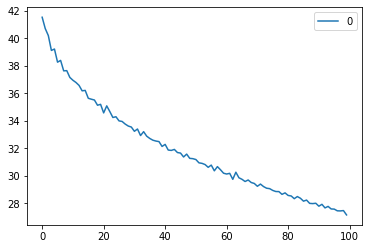

In [13]:
print(len(train_losses))
pd.DataFrame(train_losses).plot()

In [14]:
MODEL_STATE_PATH = f"/data/ajayago/druid/paper_intermediate/model_checkpoints/benchmarks/TUGDA_with_tcga_raw_mutations_filtered_drugs_sample{sample_id}/"

# torch.save(model.state_dict(), f"{MODEL_STATE_PATH}/model.pth")

In [15]:
model.load_state_dict(
    torch.load(f"{MODEL_STATE_PATH}/model.pth", map_location=str(model.device),)
)

<All keys matched successfully>

## Evaluation

In [16]:
model.eval()

TugdaWithRawMutation(
  (feature_extractor): Sequential(
    (0): Linear(in_features=324, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (latent_basis): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (S): Linear(in_features=64, out_features=6, bias=True)
  (A): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
  )
  (domain_classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [17]:
# # All datasets
# res = EvaluationTestbed.run(
#     {
#         model: [
#             AggCategoricalAnnotatedCellLineDataset(
#                 is_train=False,
#                 only_cat_one_drugs=False,
#                 scale_y=False,
#                 use_k_best_worst=None,
#             ),
#             AggCategoricalAnnotatedPdxDataset(
#                 apply_train_test_filter=False,
#                 is_train=False,
#                 only_cat_one_drugs=False,
#                 include_all_cell_line_drugs=True,
#             ),
#             AggCategoricalAnnotatedTcgaDataset(
#                 apply_train_test_filter=False,
#                 is_train=False,
#                 only_cat_one_drugs=False,
#                 include_all_cell_line_drugs=True,
#             ),
#             AggCategoricalAnnotatedMooresDataset(
#                 is_train=False, only_cat_one_drugs=False, include_all_cell_line_drugs=True
#             ),
#             AggCategoricalAnnotatedRad51Dataset(
#                 is_train=False, only_cat_one_drugs=False, include_all_cell_line_drugs=True
#             ),
#         ],
#     },
# )
# pd.set_option("display.max_rows", 100)
# res_df = pd.DataFrame(res)
# res_df.set_index(["model", "dataset", "metric"], inplace=True)
# res_df

## Drug Specific Analysis

In [18]:
from scipy import stats
from numpy import argmax
from sklearn.metrics import roc_curve

### TCGA

In [19]:
patient_dataset = AggCategoricalAnnotatedTcgaDatasetFilteredByDrug(
                is_train=False,
                filter_for="tcga", sample_id = sample_id
            )
patient_results = model(patient_dataset)
patient_pp_out = model.postprocess(patient_dataset, patient_results)
y_pred, y_true = patient_pp_out

y_pred.reset_index(drop=True, inplace=True)
y_true.reset_index(drop=True, inplace=True)

y_pred_pivotted = y_pred.pivot_table(
                "response", "submitter_id", "drug_name"
            )
y_pred_pivotted = y_pred_pivotted.fillna(0)
dict_idx_drug = pd.DataFrame(y_pred_pivotted.columns).to_dict()["drug_name"]
dict_id_drug = {}

for patient_id, predictions in y_pred_pivotted.iterrows():

    cur_pred_scores = predictions.values
    cur_recom_drug_idx = np.argsort(cur_pred_scores)[:-11:-1]
    #
    dict_recom_drug = {}
    for idx, cur_idx in enumerate(cur_recom_drug_idx):
        dict_recom_drug[
            dict_idx_drug[cur_idx]
        ] = f"{cur_pred_scores[cur_idx]} ({idx+1})"
    #
    dict_id_drug[patient_id] = dict_recom_drug

predictions_display_tcga = pd.DataFrame.from_dict(dict_id_drug)

na_mask = y_pred.response.isna()
if na_mask.sum():
    print(
        f"[KaplanMeierFitterMetric] Found {na_mask.sum()} rows with invalid response values"
    )
    y_pred = y_pred[~na_mask]
    y_true = y_true.loc[~(na_mask.values)]
na_mask = y_true.response.isna()
y_true = y_true[~na_mask]
y_pred = y_pred[~na_mask]
print(y_pred.shape)
y_pred.head()
y_combined = y_pred.merge(y_true, on=["submitter_id", "drug_name"])

from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

drugs_with_enough_support = [
    "CISPLATIN",
    "PACLITAXEL",
    "5-FLUOROURACIL",
    "CYCLOPHOSPHAMIDE",
    "DOCETAXEL",
    "GEMCITABINE",
]


# for drug_name in y_true.drug_name.unique():
for drug_name in drugs_with_enough_support:
    try:
        roc = roc_auc_score(
            y_true[y_true.drug_name == drug_name].response.values,
            y_pred[y_pred.drug_name == drug_name].response.values,
            average="micro",
        )
        aupr = average_precision_score(
            y_true[y_true.drug_name == drug_name].response.values,
            y_pred[y_pred.drug_name == drug_name].response.values,
            average="micro",
        )
        # Choosing the right threshold for F1, accuracy and precision calculation from ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        fpr, tpr, thresholds = roc_curve(
            y_true[y_true.drug_name == drug_name].response.values,
            y_pred[y_pred.drug_name == drug_name].response.values,
        )
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        
        f1 = f1_score(
            y_true[y_true.drug_name == drug_name].response.values,
            (y_pred[y_pred.drug_name == drug_name].response.values > best_thresh).astype(int),
#             average="micro",
        )
        acc_score = accuracy_score(
            y_true[y_true.drug_name == drug_name].response.values,
            (y_pred[y_pred.drug_name == drug_name].response.values > best_thresh).astype(int),
        )
        prec_score = precision_score(
            y_true[y_true.drug_name == drug_name].response.values,
            (y_pred[y_pred.drug_name == drug_name].response.values > best_thresh).astype(int),
        )
        rec_score = recall_score(
            y_true[y_true.drug_name == drug_name].response.values,
            (y_pred[y_pred.drug_name == drug_name].response.values > best_thresh).astype(int),
        )
        spearman_stats = stats.spearmanr(
            y_true[y_true.drug_name == drug_name].response.values,
            y_pred[y_pred.drug_name == drug_name].response.values,
        )
        mw_stats = stats.mannwhitneyu(
            y_combined[
                (y_combined.drug_name == drug_name) & (y_combined.response_y == 0)
            ].response_x.values,
            y_combined[
                (y_combined.drug_name == drug_name) & (y_combined.response_y == 1)
            ].response_x.values,
            alternative="greater",
        )
        denominator = (
            y_combined[
                (y_combined.drug_name == drug_name) & (y_combined.response_y == 0)
            ].shape[0]
            * y_combined[
                (y_combined.drug_name == drug_name) & (y_combined.response_y == 1)
            ].shape[0]
        )
        print(f"AUROC for {drug_name}: {roc}")
        print(f"AUPR for {drug_name}: {aupr}")
        print(f"F1 for {drug_name}: {f1}")
        print(f"Accuracy Score for {drug_name}: {acc_score}")
        print(f"Precision Score for {drug_name}: {prec_score}")
        print(f"Recall Score for {drug_name}: {rec_score}")
        print(
            f"Spearman for {drug_name}: {round(spearman_stats.correlation, 4)} (p-val: {round(spearman_stats.pvalue, 4)})"
        )
        print(
            f"Mann-Whitney for {drug_name}: {round(mw_stats.statistic/denominator, 4)} (p-val: {round(mw_stats.pvalue, 4)})"
        )
    except Exception as e:
        print(f"Error processing {drug_name} - {e}")

drugs_with_enough_support2 = ["CISPLATIN", "PACLITAXEL", "5-FLUOROURACIL"]

print("For CISPLATIN, PACLITAXEL and 5-FU")
roc = roc_auc_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values,
    average="micro",
)
aupr = average_precision_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values,
    average="micro",
)
# Choosing the right threshold for F1, accuracy and precision calculation from ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
fpr, tpr, thresholds = roc_curve(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values,
)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

f1 = f1_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    (y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values> best_thresh).astype(int),
#     average="micro",
)
acc_score = accuracy_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    (y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values> best_thresh).astype(int),
)
prec_score = precision_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    (y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values> best_thresh).astype(int),
)
rec_score = recall_score(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    (y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values> best_thresh).astype(int),
)
spearman_stats = stats.spearmanr(
    y_true[y_true.drug_name.isin(drugs_with_enough_support2)].response.values,
    y_pred[y_pred.drug_name.isin(drugs_with_enough_support2)].response.values,
)
mw_stats = stats.mannwhitneyu(
    y_combined[
        (y_combined.drug_name.isin(drugs_with_enough_support2))
        & (y_combined.response_y == 0)
    ].response_x.values,
    y_combined[
        (y_combined.drug_name.isin(drugs_with_enough_support2))
        & (y_combined.response_y == 1)
    ].response_x.values,
    alternative="greater",
)
denominator = (
    y_combined[
        (y_combined.drug_name.isin(drugs_with_enough_support2))
        & (y_combined.response_y == 0)
    ].shape[0]
    * y_combined[
        (y_combined.drug_name.isin(drugs_with_enough_support2))
        & (y_combined.response_y == 1)
    ].shape[0]
)

print(f"Overall AUROC: {roc}")
print(f"Overall AUPR: {aupr}")
print(f"Overall F1: {f1}")
print(f"Overall Accuracy Score: {acc_score}")
print(f"Overall Precision Score: {prec_score}")
print(f"Overall Recall Score: {rec_score}")
print(
    f"Overall Spearman: {round(spearman_stats.correlation, 4)} (p-val: {round(spearman_stats.pvalue, 4)})"
)
print(
    f"Overall Mann-Whitney: {round(mw_stats.statistic/denominator, 4)} (p-val: {round(mw_stats.pvalue, 4)})"
)




(126, 3)
AUROC for CISPLATIN: 0.37777777777777777
AUPR for CISPLATIN: 0.7124837884330469
F1 for CISPLATIN: 0.31578947368421056
Accuracy Score for CISPLATIN: 0.3333333333333333
Precision Score for CISPLATIN: 0.75
Recall Score for CISPLATIN: 0.2
Spearman for CISPLATIN: -0.1784 (p-val: 0.2771)
Mann-Whitney for CISPLATIN: 0.6222 (p-val: 0.1393)
AUROC for PACLITAXEL: 0.2761904761904761
AUPR for PACLITAXEL: 0.7260341304540678
F1 for PACLITAXEL: 0.8636363636363636
Accuracy Score for PACLITAXEL: 0.7692307692307693
Precision Score for PACLITAXEL: 0.8260869565217391
Recall Score for PACLITAXEL: 0.9047619047619048
Spearman for PACLITAXEL: -0.3058 (p-val: 0.1287)
Mann-Whitney for PACLITAXEL: 0.7238 (p-val: 0.0691)
AUROC for 5-FLUOROURACIL: 0.6428571428571429
AUPR for 5-FLUOROURACIL: 0.7774145635494177
F1 for 5-FLUOROURACIL: 0.8421052631578948
Accuracy Score for 5-FLUOROURACIL: 0.76
Precision Score for 5-FLUOROURACIL: 0.8
Recall Score for 5-FLUOROURACIL: 0.8888888888888888
Spearman for 5-FLUOROURAC